## Setup

In [1]:
%matplotlib inline

# External modules
import ast
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os
from pathlib import Path

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/isuelogit


In [3]:
# Internal modules
from src import isuelogit as isl

In [4]:
# Seed
_SEED = 2022

## Read network data from Fresno

In [5]:
network_name = 'Fresno'

# To write estimation report and set seed for all algorithms involving some randomness  
estimation_reporter = isl.writer.Reporter(
    folderpath = isl.config.dirs['output_folder'] + 'estimations/' + network_name, seed = _SEED)

# Reader of geospatial and spatio-temporal data
data_reader = isl.etl.DataReader(network_key=network_name)

# First Tuesday of October, 2020
data_reader.select_period(date = '2020-10-06', hour = 16)

# Read nodes data
nodes_df = pd.read_csv(isl.dirs['input_folder'] + '/network-data/nodes/'  + 'fresno-nodes-data.csv')

# Read spatiotemporal link data
links_df = pd.read_csv(
    isl.dirs['input_folder'] + 'network-data/links/' + str(data_reader.options['selected_date'])+ '-fresno-link-data.csv',
    converters={"link_key": ast.literal_eval,"pems_id": ast.literal_eval})


Selected date is 2020-10-06, Tuesday at 16:00


## Build network

In [6]:
network_generator = isl.factory.NetworkGenerator()

A = network_generator.generate_adjacency_matrix(links_keys=list(links_df['link_key'].values))

fresno_network = \
    network_generator.build_fresno_network(A=A, links_df=links_df, nodes_df=nodes_df, network_name= network_name)


Creating Fresno network

Nodes: 1789, Links: 2413


### OD matrix

In [7]:
network_generator.read_OD(network=fresno_network, sparse=True)

# Average counts in 2020: 2213 and in 2021: 2152, which equates a scale factor of 0.97 in 2021
fresno_network.scale_OD(scale = 2152/2213)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.34839999994 trips were loaded among 6970 o-d pairs
OD was scaled with factor 0.9724356077722549


### Paths

In [8]:
paths_generator = isl.factory.PathsGenerator()

# # Generate and Load paths in network
# paths_generator.load_k_shortest_paths(network = fresno_network, k=3)

paths_generator.read_paths(network=fresno_network, update_incidence_matrices=True)

26380 paths were read in 5.5[s]| 100.0% 
26380 paths were loaded in the network
Updating incidence matrices
Matrix D (2413, 26380) generated in 18.1[s]
Matrix M (6970, 26380) generated in 1.1[s] 
Matrix C (26380, 26380) generated in 4.4[s]


### Link performance functions

In [9]:
bpr_parameters_df = pd.DataFrame({'link_key': links_df['link_key'],
                                  'alpha': links_df['alpha'],
                                  'beta': links_df['beta'],
                                  'tf': links_df['tf'],
                                  'k': pd.to_numeric(links_df['k'], errors='coerce', downcast='float')
                                  })

# Normalize free flow travel time between 0 and 1
bpr_parameters_df['tf'] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(np.array(bpr_parameters_df['tf']).reshape(-1, 1)))

fresno_network.set_bpr_functions(bprdata=bpr_parameters_df)

### Feature Engineering

In [10]:
fresno_network.load_features_data(links_df, link_key = 'link_key')

isl.etl.feature_engineering_fresno(links=fresno_network.links, network=fresno_network)

Features values of links with a type different than LWRLK were set to 0
New features: ['low_inc', 'high_inc', 'no_incidents', 'no_bus_stops', 'no_intersections', 'tt_sd_adj', 'tt_reliability']


In [11]:
features_list = ['median_inc', 'intersections', 'incidents', 'bus_stops', 'median_age',
                 'tt_avg', 'tt_sd','tt_var', 'tt_cv', 'tt_sd_adj','tt_reliability',
                 'speed_ref_avg', 'speed_avg', 'speed_hist_avg','speed_sd','speed_hist_sd','speed_cv']


# Normalization of features to range [0,1]
linkdata = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(fresno_network.Z_data[features_list].values))
linkdata.columns = features_list
linkdata.insert(0, 'link_key', fresno_network.links_keys)

fresno_network.load_features_data(linkdata)

### Traffic counts

In [12]:
counts_df = pd.read_csv(isl.dirs['input_folder'] + '/network-data/links/' \
                            + str(data_reader.options['selected_date']) + '-fresno-link-counts' + '.csv',
                        converters={'link_key': ast.literal_eval})

counts = dict(zip(counts_df['link_key'].values, counts_df['counts'].values))

fresno_network.load_traffic_counts(counts=counts)

## Descriptive statistics

### Link coverage

In [13]:
total_counts_observations = np.count_nonzero(~np.isnan(np.array(list(counts.values()))))

total_links = np.array(list(counts.values())).shape[0]

print('\nTotal link counts observations: ' + str(total_counts_observations))
print('Link coverage: ' + "{:.1%}".format(round(total_counts_observations / total_links, 4)))


Total link counts observations: 141
Link coverage: 5.8%


### Networks topology

In [14]:
isl.descriptive_statistics.summary_table_networks([fresno_network])

,network,nodes,links,ods,paths
0,Fresno,1789,2413,6970,26380


### Links data

In [15]:
summary_table_links_df = fresno_network.Z_data
estimation_reporter.write_table(df = summary_table_links_df, filename = 'links_data.csv', float_format = '%.3f')
summary_table_links_df

,link_type,alpha,beta,tf,k,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],...,median_age,incidents,bus_stops,intersections,high_inc,low_inc,no_incidents,no_bus_stops,no_intersections,tt_reliability
0,LWRLK,0.15,4.0,0.098,1.800000e+03,0,NaN,1800.0,0.098,45,...,0.676087,0.748,0.435,0.30,1,0,0,0,0,0.403293
1,LWRLK,0.15,4.0,0.169,1.800000e+03,0,NaN,1800.0,0.169,50,...,0.747826,0.748,0.435,0.05,1,0,0,0,0,0.474777
2,LWRLK,0.15,4.0,0.396,2.400000e+03,0,NaN,2400.0,0.396,65,...,0.747826,0.748,0.435,0.05,1,0,0,0,0,0.474777
3,LWRLK,0.15,4.0,0.192,2.000000e+03,0,NaN,2000.0,0.192,25,...,0.747826,0.748,0.435,0.10,1,0,0,0,0,0.969572
4,LWRLK,0.15,4.0,0.105,1.800000e+03,0,NaN,1800.0,0.105,35,...,0.747826,0.748,0.435,0.10,1,0,0,0,0,0.477713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,PQULK,0.15,4.0,0.000,4.990000e+09,0,NaN,inf,0.000,99999,...,0.000000,0.000,0.000,0.00,0,0,0,0,0,0.000000
2409,PQULK,0.15,4.0,0.000,4.990000e+09,0,NaN,inf,0.000,99999,...,0.000000,0.000,0.000,0.00,0,0,0,0,0,0.000000
2410,LWRLK,0.15,4.0,0.045,1.800000e+03,0,NaN,1800.0,0.045,65,...,0.628261,1.000,0.435,0.45,1,0,0,0,0,0.511839
2411,LWRLK,0.15,4.0,0.107,2.400000e+03,0,NaN,2400.0,0.107,65,...,0.978261,0.500,0.435,0.70,0,1,0,0,0,0.501516


In [16]:
summary_table_links_df.describe()

,alpha,beta,tf,k,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,...,median_age,incidents,bus_stops,intersections,high_inc,low_inc,no_incidents,no_bus_stops,no_intersections,tt_reliability
count,2.413000e+03,2413.0,2413.000000,2.413000e+03,2413.000000,141.000000,2413.0,2413.000000,2413.000000,1.840000e+03,...,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.0,2413.0,2413.0,2413.000000
mean,1.500000e-01,4.0,0.150823,1.439305e+09,0.058433,2152.176596,inf,0.150823,28872.664318,9.170812e+08,...,0.483083,0.522609,0.299036,0.228530,0.501450,0.210112,0.0,0.0,0.0,0.348203
std,2.776133e-17,0.0,0.172458,2.261116e+09,0.234610,844.686249,NaN,0.172458,45293.922006,6.053116e+08,...,0.323928,0.341960,0.213662,0.217516,0.500102,0.407472,0.0,0.0,0.0,0.232400
min,1.500000e-01,4.0,0.000000,1.800000e+03,0.000000,417.800000,1800.0,0.000000,15.000000,1.685461e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,1.500000e-01,4.0,0.000000,1.800000e+03,0.000000,1625.000000,1800.0,0.000000,40.000000,4.416712e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,1.500000e-01,4.0,0.121000,1.800000e+03,0.000000,2045.000000,1800.0,0.121000,45.000000,4.498919e+08,...,0.623913,0.748000,0.435000,0.200000,1.000000,0.000000,0.0,0.0,0.0,0.467086
75%,1.500000e-01,4.0,0.205000,4.990000e+09,0.000000,2510.000000,NaN,0.205000,99999.000000,1.626669e+09,...,0.686957,0.748000,0.435000,0.331000,1.000000,0.000000,0.0,0.0,0.0,0.487949
max,1.500000e-01,4.0,2.113000,4.990000e+09,1.000000,4564.000000,inf,2.113000,99999.000000,1.626774e+09,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000


## Bilevel Estimation

In [17]:
utility_function = isl.estimation.UtilityFunction(
    features_Y=['tt'],
    initial_values={'tt': 0},
)

equilibrator_norefined = isl.equilibrium.LUE_Equilibrator(
    network=fresno_network,
    paths_generator=paths_generator,
    utility_function=utility_function,
    max_iters=100,
    method='fw',
    iters_fw=10,
    column_generation={'n_paths': 4,
                       'ods_coverage': 0.1,
                       'paths_selection': 4},
    path_size_correction=1
)

outer_optimizer_norefined = isl.estimation.OuterOptimizer(
    method='ngd',
    iters=1,
    eta=1e-1,
)

learner_norefined = isl.estimation.Learner(
    equilibrator=equilibrator_norefined,
    outer_optimizer=outer_optimizer_norefined,
    utility_function=utility_function,
    network=fresno_network,
    name = 'norefined'
)

equilibrator_refined = isl.equilibrium.LUE_Equilibrator(
    network=fresno_network,
    paths_generator=paths_generator,
    utility_function=utility_function,
    max_iters=100,
    method='fw',
    iters_fw=10,
    path_size_correction=1
)

outer_optimizer_refined = isl.estimation.OuterOptimizer(
    method='lm',
    # method='ngd',
    iters=1,
    # eta=5e-1,
)

learner_refined = isl.estimation.Learner(
    network=fresno_network,
    equilibrator=equilibrator_refined,
    outer_optimizer=outer_optimizer_refined,
    utility_function=utility_function,
    name = 'refined'
)

### a) Benchmark predictions

#### Naive prediction using mean counts

In [18]:
mean_counts_prediction_loss, mean_count_benchmark_model \
    = isl.estimation.mean_count_prediction(counts=np.array(list(counts.values()))[:, np.newaxis])

print('\nObjective function under mean count prediction: ' + '{:,}'.format(round(mean_counts_prediction_loss, 1)))


Objective function under mean count prediction: 99,889,346.8


#### Naive prediction where travelers make equilikely choices

In [19]:
equilikely_prediction_loss, predicted_counts_equilikely \
    = isl.estimation.loss_counts_equilikely_choices(
    network = fresno_network,
    equilibrator=equilibrator_norefined,
    counts=fresno_network.counts_vector,
    utility_function=utility_function)

print('Objective function under equilikely route choices: ' + '{:,}'.format(round(equilikely_prediction_loss, 1)))

Objective function under equilikely route choices: 311,310,462.2


### b) Model with travel time feature only

#### No refined stage

In [20]:
learning_results_norefined, inference_results_norefined, best_iter_norefined = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True)

theta_norefined = learning_results_norefined[best_iter_norefined]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '0.0E+00'}

SUE via fw (max iters: 100)
Performed path size correction with factor 1

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -155,801.21
Final Fisk Objective: -155,801.21
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 152.1 [s]
Initial objective: 311,310,462
Initial RMSE: 1485.9
Initial Normalized RMSE: 0.69

Iteration : 2/10

Learning params via ngd (1 iters, eta = 1.0E-01)

theta: {'tt': '-1.0E-01'}------| 0.0% 
time: 197.1[s]

SUE via fw (max iters: 100)

Column generation: 4 paths per od, 10.0% od coverage, demand sampling
158 paths added/replaced among 156 ods (New total paths: 26538)
Performed path size correction with factor 1

Path selection: dissimilarity_weight: 0, paths per od: 4
158 paths removed among 156 ods (New total paths: 26380)
Performed path size correction with factor 1

Equilibrium gaps: ['2E-05']
Initial Fisk Objective: -160,348.02
Final F

#### Refined stage

In [21]:
learner_refined.utility_function.initial_values = theta_norefined

learning_results_refined, inference_results_refined, best_iter_refined = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True)

theta_refined = learning_results_refined[best_iter_refined]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-9.0E-01'}

SUE via fw (max iters: 100)
Performed path size correction with factor 1

Equilibrium gaps: ['2E-03', '0E+00']
Initial Fisk Objective: -190,125.41
Final Fisk Objective: -185,260.32
Improvement Fisk Objective: 2.56%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 167.4 [s]
Initial objective: 230,731,996
Initial RMSE: 1279.2
Initial Normalized RMSE: 0.594

Iteration : 2/10

Learning params via lm (1 iters)

Damping factors: ['1.0E-02']---| 0.0% 
theta: {'tt': '-1.5E+00'}
time: 176.2[s]

SUE via fw (max iters: 100)
Performed path size correction with factor 1

Equilibrium gaps: ['3E-03', '0E+00']
Initial Fisk Objective: -208,435.56
Final Fisk Objective: -201,859.17
Improvement Fisk Objective: 3.16%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 162.9 [s]

Time current iteration: 339.3 [s]
Current objective_value: 223,500,453
Current objective improvement: 3.13%
Current RMSE: 1259.0
Current Normalized RM

#### Report

In [22]:
estimation_reporter.add_items_report(
    selected_date = data_reader.options['selected_date'],
    selected_hour = data_reader.options['selected_hour'],
    selected_od_periods = data_reader.options['od_periods'],
    mean_counts=round(mean_count_benchmark_model,1),
    mean_counts_prediction_loss = round(mean_counts_prediction_loss,1),
    equilikely_prediction_loss = round(equilikely_prediction_loss,1)
)

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined,
    theta_refined= theta_refined,
    best_objective_norefined = round(learning_results_norefined[best_iter_norefined]['objective'],1),
    best_objective_refined = round(learning_results_refined[best_iter_refined]['objective'],1),
)

# Summary with most relevant options, prediction error, initial parameters, etc
estimation_reporter.write_estimation_report(
    network=fresno_network,
    learners=[learner_norefined, learner_refined],
    utility_function=utility_function)

# Write tables with results on learning and inference
estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined,
    results_refined=learning_results_refined,
    network = fresno_network,
    utility_function = utility_function)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined,
    results_refined=inference_results_refined,
    float_format = '%.3f')

#### Visualizations

##### Convergence

/Users/pablo/OneDrive/data-science/github/isuelogit/venv-isuelogit/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/pablo/OneDrive/data-science/github/isuelogit/venv-isuelogit/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/pablo/OneDrive/data-science/github/isuelogit/venv-isuelogit/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


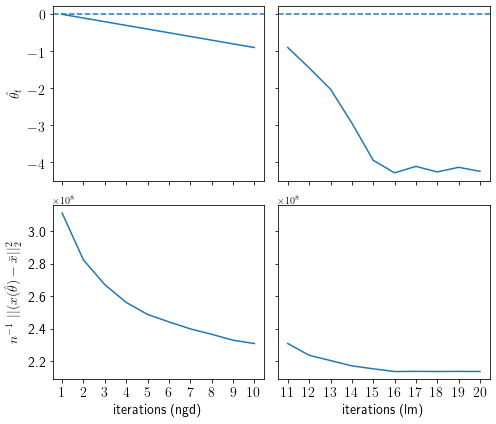

In [23]:
results_df = isl.descriptive_statistics \
    .get_loss_and_estimates_over_iterations(results_norefined=learning_results_norefined
                                            , results_refined=learning_results_refined)

fig = isl.visualization.Artist().convergence(
    results_norefined_df=results_df[results_df['stage'] == 'norefined'],
    results_refined_df=results_df[results_df['stage'] == 'refined'],
    filename='convergence_' + fresno_network.key,
    methods=[outer_optimizer_norefined.method.key, outer_optimizer_refined.method.key],
    folder = estimation_reporter.dirs['estimation_folder'],
    simulated_data = False
)

##### Distribution of errors across link counts

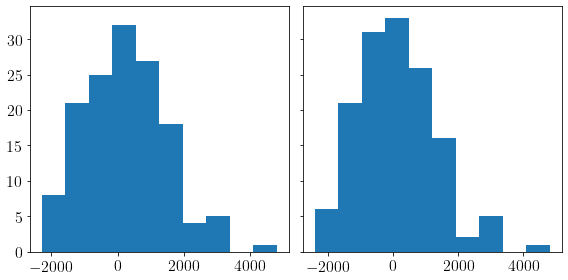

In [24]:
best_predicted_counts_norefined = np.array(list(learning_results_norefined[best_iter_norefined]['x'].values()))[:, np.newaxis]
best_predicted_counts_refined = np.array(list(learning_results_refined[best_iter_refined]['x'].values()))[:, np.newaxis]

fig, axs = plt.subplots(1, 2, sharey='all', tight_layout=True, figsize=(8, 4))

axs[0].hist(isl.estimation.error_by_link(observed_counts=np.array(list(counts.values()))[:, np.newaxis],
                                         predicted_counts=best_predicted_counts_norefined))
axs[1].hist(isl.estimation.error_by_link(observed_counts=np.array(list(counts.values()))[:, np.newaxis],
                                         predicted_counts=best_predicted_counts_refined))

for axi in [axs[0], axs[1]]:
    axi.tick_params(axis='x', labelsize=16)
    axi.tick_params(axis='y', labelsize=16)

plt.show()

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'distribution_predicted_error_counts.pdf',
            pad_inches=0.1, bbox_inches="tight")

### c) Model with all features

In [25]:
utility_function_full_model = isl.estimation.UtilityFunction(
    features_Y=['tt'],
    features_Z= ['tt_cv', 'incidents', 'intersections', 'bus_stops', 'median_inc'],
    signs = {'tt': '-', 'tt_cv':'-', 'incidents':'-', 'intersections':'-', 'bus_stops':'-', 'median_inc':'+'}
)

# Update utility functions of no refined and refined learners
learner_norefined.utility_function = utility_function_full_model
learner_refined.utility_function = utility_function_full_model

#Initialize value with the estimate obtained from b)
learner_norefined.utility_function.initial_values = theta_refined

estimation_reporter = isl.writer.Reporter(
    folderpath = isl.config.dirs['output_folder'] + 'estimations/' + network_name, seed =_SEED)

#### No refined stage

In [26]:
learning_results_norefined, inference_results_norefined, best_iter_norefined = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True)

theta_norefined_full_model = learning_results_norefined[best_iter_norefined]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-4.3E+00', 'tt_cv': '0.0E+00', 'incidents': '0.0E+00', 'intersections': '0.0E+00', 'bus_stops': '0.0E+00', 'median_inc': '0.0E+00'}

SUE via fw (max iters: 100)
Performed path size correction with factor 1

Equilibrium gaps: ['1E-03', '0E+00']
Initial Fisk Objective: -297,753.69
Final Fisk Objective: -271,149.35
Improvement Fisk Objective: 8.94%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 183.0 [s]
Initial objective: 213,472,899
Initial RMSE: 1230.4
Initial Normalized RMSE: 0.572

Iteration : 2/10

Learning params via ngd (1 iters, eta = 1.0E-01)

theta: {'tt': '-4.3E+00', 'tt_cv': '4.8E-02', 'incidents': '5.8E-02', 'intersections': '1.9E-02', 'bus_stops': '3.6E-02', 'median_inc': '5.1E-02'}
time: 777.7[s]

SUE via fw (max iters: 100)

Column generation: 4 paths per od, 10.0% od coverage, demand sampling
1397 paths added/replaced among 697 ods (New total paths: 27777)
Performed path size correction with 

#### Refined stage

In [27]:
learner_refined.utility_function.initial_values = theta_norefined_full_model

learning_results_refined, inference_results_refined, best_iter_refined = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True)

theta_refined_full_model = learning_results_refined[best_iter_refined]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-4.3E+00', 'tt_cv': '1.5E-01', 'incidents': '3.1E-01', 'intersections': '1.3E-01', 'bus_stops': '1.8E-01', 'median_inc': '2.7E-01'}

SUE via fw (max iters: 100)
Performed path size correction with factor 1

Equilibrium gaps: ['3E-03', '2E-04', '1E-03', '3E-03', '0E+00']
Initial Fisk Objective: 763,619.74
Final Fisk Objective: 910,520.81
Improvement Fisk Objective: 19.24%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 341.0 [s]
Initial objective: 211,238,366
Initial RMSE: 1224.0
Initial Normalized RMSE: 0.569

Iteration : 2/10

Learning params via lm (1 iters)

Damping factors: ['1.0E-02']---| 0.0% 
theta: {'tt': '-1.2E+01', 'tt_cv': '1.9E-01', 'incidents': '3.7E-01', 'intersections': '8.4E-01', 'bus_stops': '1.3E+00', 'median_inc': '1.1E+00'}
time: 1140.9[s]

SUE via fw (max iters: 100)
Performed path size correction with factor 1

Equilibrium gaps: ['3E-03', '1E-04', '0E+00']
Initial Fisk Objective: 2,928,

KeyboardInterrupt: 

#### Report

In [ ]:
estimation_reporter.add_items_report(
    selected_date = data_reader.options['selected_date'],
    selected_hour = data_reader.options['selected_hour'],
    selected_od_periods = data_reader.options['od_periods'],
    mean_counts=round(mean_count_benchmark_model,1),
    mean_counts_prediction_loss = round(mean_counts_prediction_loss,1),
    equilikely_prediction_loss = round(equilikely_prediction_loss,1)
)

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined_full_model,
    theta_refined= theta_refined_full_model,
    best_objective_norefined = round(learning_results_norefined[best_iter_norefined]['objective'],1),
    best_objective_refined = round(learning_results_refined[best_iter_refined]['objective'],1),
)

estimation_reporter.write_estimation_report(
    network=fresno_network,
    learners=[learner_norefined, learner_refined],
    utility_function=utility_function_full_model)

estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined,
    results_refined=learning_results_refined,
    network = fresno_network,
    utility_function = utility_function_full_model)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined,
    results_refined=inference_results_refined,
    float_format = '%.3f')

### d) Model including features with parameters with expected sign

In [ ]:
features_Y,features_Z = isl.estimation.feature_selection(utility_function_full_model,
                                                          theta = theta_refined_full_model,
                                                          criterion = 'sign')

utility_function_feature_selection_model = isl.estimation.UtilityFunction(
    features_Y = features_Y,
    features_Z = features_Z
)

learner_norefined.utility_function = utility_function_feature_selection_model
learner_refined.utility_function = utility_function_feature_selection_model

learner_norefined.utility_function.initial_values = theta_refined_full_model

estimation_reporter = isl.writer.Reporter(
    folderpath = isl.config.dirs['output_folder'] + 'estimations/' + network_name, seed = _SEED)

#### No refined stage

In [ ]:
learning_results_norefined, inference_results_norefined, best_iter_norefined = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, 
                                            link_report=False, iteration_report = True)

theta_norefined_feature_selection_model = learning_results_norefined[best_iter_norefined]['theta']

#### Refined stage

In [ ]:
learner_refined.utility_function.initial_values = theta_norefined_feature_selection_model

learning_results_refined, inference_results_refined, best_iter_refined = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, 
                                          link_report=False, iteration_report = True)

theta_refined_feature_selection_model = learning_results_refined[best_iter_refined]['theta']

#### Report

In [ ]:
estimation_reporter.add_items_report(
    selected_date = data_reader.options['selected_date'],
    selected_hour = data_reader.options['selected_hour'],
    selected_od_periods = data_reader.options['od_periods'],
    mean_counts=round(mean_count_benchmark_model,1),
    mean_counts_prediction_loss = round(mean_counts_prediction_loss,1),
    equilikely_prediction_loss = round(equilikely_prediction_loss,1)
)

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined_feature_selection_model,
    theta_refined= theta_refined_feature_selection_model,
    best_objective_norefined = round(learning_results_norefined[best_iter_norefined]['objective'],1),
    best_objective_refined = round(learning_results_refined[best_iter_refined]['objective'],1),
)

estimation_reporter.write_estimation_report(
    network=fresno_network,
    learners=[learner_norefined, learner_refined],
    utility_function=utility_function_feature_selection_model)

estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined,
    results_refined=learning_results_refined,
    network = fresno_network,
    utility_function = utility_function_feature_selection_model)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined,
    results_refined=inference_results_refined,
    float_format = '%.3f')

### e) Model with all features and constrained optimization on expected signs of parameters

In [ ]:
# Update utility functions of no refined and refined learners
learner_norefined.utility_function = utility_function_full_model
learner_refined.utility_function = utility_function_full_model

#Initialize value with the estimate obtained from b)
#learner_norefined.utility_function.initial_values = theta_refined

#### No refined stage

In [ ]:
# learning_results_norefined, inference_results_norefined, best_iter_norefined = \
#     learner_norefined.statistical_inference(h0=0, bilevel_iters=3, alpha=0.05, constrained_optimization = {'sign':True, 'fix':True}, 
#                                             link_report=False, iteration_report = True)

# theta_norefined_full_model = learning_results_norefined[best_iter_norefined]['theta']

#### Refined stage